# 目錄

先將數據導入，分成不同區間[1數據導入]，

而後定義各像函數(指標，相關係數，交易)[2函數區塊]，

之後選擇適合的天數，及輸出正負相關的不同結果(做多,做空,多空)[3流程]，

在用正負相關的指標建構類神經模型[4BPN]。

- [1數據導入](#1數據導入)
- [1.1-前200筆生成指標(用以盡可能嘗試指標不同構面)](#1.1-前200筆生成指標(用以盡可能嘗試指標不同構面))    
    - [1.2-500筆用於尋找規律](#1.2-500筆用於尋找規律)    
    - [1.3-300筆用於驗證](#1.3-300筆用於驗證)


- [2函數區塊](#2函數區塊)
- [2.1各項指標函數](##2.1各項指標函數)
- [2.2指標表生成(輪廓)](#2.2指標表生成(輪廓))    
- [2.3參數設定[資料區間]](#2.3參數設定[資料區間])
- [2.4相關分析](##2.4相關分析)
- [2.5交易相關函數](#2.5交易相關函數)
- [2.5.1例子:負相關[0]](#2.5.1例子負相關0)


- [3流程](#3流程)
- [3.1進場評分指標天數選擇](#3.1進場評分指標天數選擇)    
- [3.2進場評分指標天數[40]](#3.2進場評分指標天數[40])    
- [3.3相關分析輸出結果](#3.3相關分析輸出結果)    
- [3.4正負相關各項輸出(做多,做空,多空)](#3.4正負相關各項輸出做多做空多空)


- [4BPN](#4bpn)    
- [4.1正負相關 6 個指標](#4.1正負相關-6-個指標)
- [4.2資料正規化](#4.2資料正規化)
- [4.3類神經參數選擇](#4.3類神經參數選擇)    
- [4.4類神經](#4.4類神經)    
- [4.5類神經交易](#4.5類神經交易)    
- [4.6類神經所有結果(做多,做空,多空)](#4.6類神經所有結果做多做空多空)

# 1數據導入

In [11]:
# 在 notebook 中使用 matplot 包含 icon
%matplotlib inline

# ---
# 每次執行時 reload 變更 model 時無需重跑
%reload_ext autoreload
%autoreload 2

# 繪圖格式設定
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus']=False # 負號正常顯示
plt.rcParams['font.family']='DFKai-sb' # 'DFKai-sb' :標楷體 

## 資料分析常用套件
# dataframe
import pandas as pd
# array
import numpy as np
# 統計相關
import scipy.stats as stats 

# 系統相關
import os
# 讀檔
df = pd.read_excel('Fitx1.xlsx',parse_dates=[0], index_col=0, encoding='big5')

df.head()

,開盤價,最高價,最低價,收盤價,成交量,期現貨價差(現貨-期貨),近遠月價差(遠月-近月),買權(Call)成交量,買權(Call)未平倉量,賣權(Put)成交量,...,自營商未平倉賣口,自營商未平倉淨口,外資及陸資未平倉買口,外資及陸資未平倉賣口,外資及陸資未平倉淨口,三大法人未平倉買口,三大法人未平倉賣口,三大法人未平倉淨口,未平倉,未平倉變化
時間,,,,,,,,,,,,,,,,,,,,,
2012-01-02,7022,7051,6928,6945,88074,7.21,-6,173222,380730,131778,...,5430,1661,24067,36378,-12311,32333,43425,-11092,62592,1669
2012-01-03,7020,7087,7002,7047,86594,6.38,-6,141409,392236,119418,...,4991,1427,25990,34433,-8443,33590,41062,-7472,61296,-1296
2012-01-04,7084,7109,7043,7072,87250,10.97,-6,131942,406549,125820,...,5218,1861,27250,32591,-5341,35508,39396,-3888,60955,-341
2012-01-05,7088,7124,7061,7119,81890,11.86,-7,119946,420481,112973,...,5445,2130,28606,32092,-3486,37351,38961,-1610,60418,-537
2012-01-06,7100,7117,7060,7084,90243,36.51,-7,114604,435878,119626,...,4970,1850,27159,29963,-2804,35135,36403,-1268,56302,-4116


## 1.1-前200筆生成指標(用以盡可能嘗試指標不同構面)

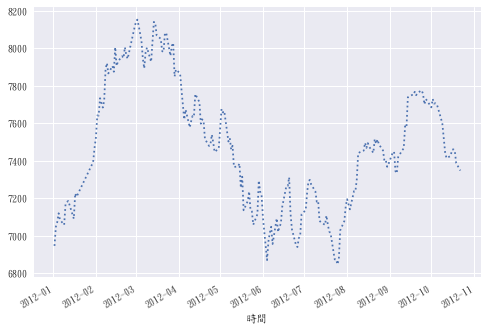

In [12]:
df.iloc[:200,3].plot(linestyle=':')

## 1.2-500筆用於尋找規律

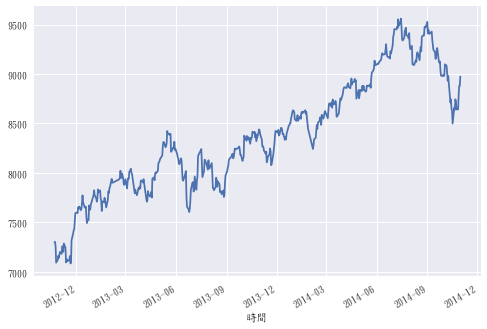

In [13]:
df.iloc[200:700,3].plot(linestyle='-')

## 1.3-300筆用於驗證

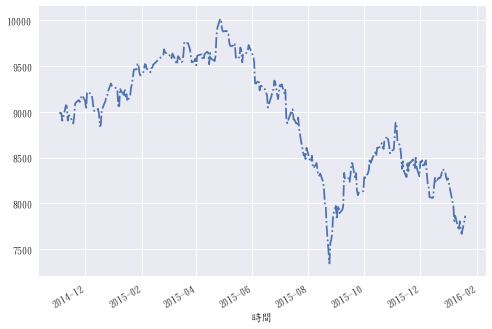

In [14]:
df.iloc[700:1000,3].plot(linestyle='-.')

# 2函數區塊

## 2.1各項指標函數

In [15]:
class signal_class:
    '''各項技術指標'''

    def __init__(self, df):
        '''
        資料區間
        開高低收定義
        '''
        self.df_price = df
        
    def ma(self, d, Close):
        '''移動平均線(MA)'''
        return Close.rolling(d).mean()

    def mtm(self, d, Close):
        '''動量指標(MTM)'''
        return (Close/Close.shift(d) - 1)*100

    def cci(self, d, High, Low, Close):
        '''趨勢指標(CCI)'''
        TP = (High + Low + Close)/3
        MA = TP.rolling(d).mean()
        MD = (MA - TP).abs().rolling(d).mean()
        CCI = (TP-MA)/(0.015*MD)
        return CCI

    def macd(self, fast, slow, d, High, Low, Close):
        '''指數平滑異同移動平均線(MACD)'''
        DI = (High + Low + 2*Close)/4
        fast_EMA = DI.ewm(span=fast).mean()
        slow_EMA = DI.ewm(span=slow).mean()
        DIF = fast_EMA - slow_EMA
        MACD = DIF.ewm(span=d).mean()
        return(DIF, MACD)

    def vol(self, d, Close, m = 2):
        '''2倍年化波動率 '''
        ret = Close.pct_change()
        v = m*ret.rolling(d).std()*100 * 252**0.5
        return v

    def kd(self, d, High, Low, Close, out=1):
        '''隨機指標(KD) K, D, RSV 值'''
        # 計算 RSV
        RSV = 100* (( Close - Low.rolling(d).min()) / 
                    (High.rolling(d).max() - Low.rolling(d).min()))
        n = len(RSV)
        arr = np.zeros((n, 2))
        K, D = arr[:,0], arr[:,1]
        K[d-1], D[d-1] = 50, 50
        for i in range(d, n):
            K[i] = K[i-1]*2/3 + RSV[i]*1/3
            D[i] = D[i-1]*2/3 + K[i]*1/3

        if out == 1:
            return K
        elif out == 2:
            return D
        elif out == 3:
            return RSV
        elif out == 0:
            return(K, D, RSV)

    def wr(self, d, High, Low, Close):
        '''計算威廉指標(W%R)'''
        WR=100* (( High.rolling(d).max() - Close ) / 
                 (High.rolling(d).max() - Low.rolling(d).min() ))
        return WR

    def rsi(self, d, High, Low, Close):
        '''相對強弱指標(RSI)'''
        df1 = Close - Close.shift(1)
        df2 = 100*(df1.apply(lambda x: 0 if x < 0 else x).rolling(d).mean() / 
                   df1.apply(lambda x: -x if x < 0 else x).rolling(d).mean())
        return(df2)

    def bb(self, d, Close, m=2):
        '''布林通道上下界, 帶寬,%B'''
        ma = Close.rolling(d).mean()
        std = Close.rolling(d).std() 
        up = ma + m*std 
        dn = ma - m*std
        bb_p = 100*(Close - dn)/(2*m*std) 
        bb_w = 100*(2*m*std)/ma
        return(bb_p,bb_w)

    def main_af2(self, x = 40):
        '''
        進場評分指標
        以未來x天(最大-今天)-0.5*(最大-最小)
        '''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        xx = pd.concat([Close.shift(-i) for i in range(0,x)],axis=1)
        hh = pd.concat([High.shift(-i) for i in range(0,x)],axis=1)
        ll = pd.concat([Low.shift(-i) for i in range(0,x)],axis=1)
        return((hh.max(axis=1)-xx.iloc[:,0])-0.5*(hh.max(axis=1)-ll.min(axis=1)))
    
    def main_kd(self,d=9):
        '''設定隨機指標(KD)'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['K'+str(d)], df['D'+str(d)], df['RSV'+str(d)] = self.kd(d, High, Low, Close, out=0)
        return df.iloc[:,4:]
    
    def main_wr(self, d=9):
        '''設定威廉指標(W%R)'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['WR'+str(d)] = self.wr(d, High, Low, Close)
        return df.iloc[:,4:]
    
    def main_rsi(self, d=9):
        '''設定相對強弱指標(RSI)'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['RSI'+str(d)] = self.rsi(d, High, Low, Close)
        return df.iloc[:,4:]
    
    def main_mtm(self, d=9):
        '''設定動量指標(MTM)'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['MTM'+str(d)] = self.mtm(d, Close)
        return df.iloc[:,4:]
    
    def main_ma(self, d=9):
        '''設定移動平均線(MA)'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['MA_'+str(d)] =  Close - self.ma(d, Close)
        return df.iloc[:,4:]
    
    def main_macd(self, fast=12, slow=26, d=9):
        '''設定指數平滑異同移動平均線(MACD)'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['DIF'+','+str(fast)+','+str(slow)+','+str(d)], df['MACD'+','+str(fast)+','+str(slow)+','+str(d)] = self.macd(fast, slow, d, High, Low, Close)
        return df.iloc[:,4:]
    
    def main_cci(self, d=14):
        '''設定趨勢指標(CCI)'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['CCI'+str(d)] = self.cci(d, High, Low, Close)
        return df.iloc[:,4:]
    
    def main_bb(self, d=9, m=2):
        '''設定布林通道指標'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['%B'+','+str(d)+','+str(m)],df['BB'+','+str(d)+','+str(m)] = self.bb(d, Close, m)
        return df.iloc[:,4:]
    
    def main_v(self, d=9, m=2):
        '''設定波動率(v)'''
        df = self.df_price.copy()
        Open, High, Low, Close = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]
        df['v'+','+str(d)+','+str(m)] = self.vol(d, Close, m)
        return df.iloc[:,4:]
    
# 各項技術指標函數
signal = signal_class(df.iloc[:,:4])
signal

## 2.2指標表生成(輪廓)

In [17]:
# 指標表
def sign_list_f(signal):
    '''指標表'''
    df_list = [
        # 計算隨機指標(KD)
        pd.concat([signal.main_kd(i)
                 for i in range(5,201)],axis=1),
        # 計算威廉指標(W%R)
        pd.concat([signal.main_wr(i)
                 for i in range(5,201)],axis=1),
        # 計算相對強弱指(RSI)
        pd.concat([signal.main_rsi(i)
                 for i in range(5,201)],axis=1),
        # 計算動量指標(MTM)
        pd.concat([signal.main_mtm(i)
                 for i in range(5,201)],axis=1),
        # 計算移動平均線(MA)
        pd.concat([signal.main_ma(i)
                 for i in range(5,201)],axis=1),
        # 計算趨勢指標(CCI)
        pd.concat([signal.main_cci(i)
                 for i in range(5,101)],axis=1),
        # 計算布林通道指標
        pd.concat([signal.main_bb(i, j/10)
                 for i in range(5,201)
                 for j in range(1, 36, 10)],axis=1),
        # 計算波動率(v)
        pd.concat([signal.main_v(i, j/10)
                 for i in range(5,201)
                 for j in range(1, 36, 10)],axis=1),
        # 計算指數平滑異同移動平均線(MACD)
        pd.concat([signal.main_macd(base+i, base+j, base+k) 
                 for base in range(0,73,9) 
                 for i in range(12,21) 
                 for j in range(22,31) 
                 for k in range(8,16)],axis=1)]
    name_list=[i.columns for i in df_list] # 記錄指標的不同參數
    # 合併所有指標
    sign_list = pd.concat(df_list+[df.iloc[:,4:]],axis=1) 
    return(sign_list, name_list) # 回傳(指標表,和不同的名稱)
(sign_list, name_list) = sign_list_f(signal) # 呼叫函數

sign_list.tail() # 指標表後5筆


,K5,D5,RSV5,K6,D6,RSV6,K7,D7,RSV7,K8,...,自營商未平倉賣口,自營商未平倉淨口,外資及陸資未平倉買口,外資及陸資未平倉賣口,外資及陸資未平倉淨口,三大法人未平倉買口,三大法人未平倉賣口,三大法人未平倉淨口,未平倉,未平倉變化
時間,,,,,,,,,,,,,,,,,,,,,
2017-12-20,45.657865,47.325079,47.204969,48.518669,48.028133,47.204969,52.287339,48.928118,56.632653,54.261268,...,8651,-4196,65699,20117,45582,71882,63947,7935,30811,-12436
2017-12-21,51.342532,48.664230,62.711864,47.666690,47.907652,45.962733,50.179137,49.345125,45.962733,54.711594,...,8474,-4320,65705,22131,43574,71583,66084,5499,87835,57024
2017-12-22,65.478355,54.268938,93.750000,63.416211,53.077172,94.915254,56.641164,51.777138,69.565217,59.662802,...,9138,-4608,66338,21169,45169,72647,65195,7452,87459,-376
2017-12-25,66.241768,58.259881,67.768595,64.867006,57.007116,67.768595,62.003200,55.185825,72.727273,61.307292,...,9640,-5217,66574,21024,45550,72705,65607,7098,88085,626
2017-12-26,46.481854,54.333872,6.962025,45.565346,53.193193,6.962025,43.656142,51.342597,6.962025,43.192203,...,10596,-6115,66042,22619,43423,72051,69507,2544,91544,3459


## 2.3參數設定[資料區間]

In [27]:

start = 200
end = start+500

test_start = start+500
test_end = test_start+300

## 2.4相關分析

In [21]:
# 由進場評分指標尋找相關性高的指標
def stat_per_af(sign_list, method, start, end):
    '''由場評分指標尋找相關性高的指標'''
    af = method.shift(-1).iloc[start:end] # 樣本內隔日(shift(-1))進場評分指標
    sign_list = sign_list.iloc[start:end] # 樣本內指標表(候選指標)
    pearson = pd.DataFrame(  # 對所有的候選指標做相關係數檢定
        {i : stats.pearsonr(af, sign_list.loc[:,i])
         for i in sign_list.columns}
    )
    pearson = pearson.T # 將相關係數表轉置
    return(pearson) # 回傳


# pearson = stat_per_af(sign_list, method, start, end)

# 相關分析篩選
def pearson_sort(num, per_lis, name_list):
    '''相關分析篩選
    num:篩選出前幾名
    per_lis:相關係數表(已排序)
    '''
    per =per_lis.copy() # 複製(避免原表受影響)相關係數表(已排序)
    cond_list = []
    cond_list.append(per.index[0]) # 將第1名放進列表
    for j in range(num-1): # 重複num-1次
        for i in name_list: # 檢查重複的技術指標，並將同種技術指標扣除
            if per.index[0] in i:
                per.drop(i,axis=0,inplace=True) # 扣除同種技術指標，取代原表
                break
        else: # 若不在技術指標裡，則
            per.drop(per.index[0],axis=0,inplace=True) # 扣除那一個指標
        cond_list.append(per.index[0]) # 扣除後再選次一名
    return cond_list # 回傳篩選後的指標名稱


In [41]:

pearson = stat_per_af(sign_list, method, start, end) # 相關係數表(樣本內)

test_pearson = stat_per_af(sign_list, method, test_start, test_end) # 相關係數表(樣本外)

max_sort_list = pearson_sort( # 相關分析篩選(前3名，由大到小)
    3,pearson.sort_values(by = [0], ascending = False), name_list
)

min_sort_list = pearson_sort( # 相關分析篩選(前3名，由小到大)
    3,pearson.sort_values(by = [0], ascending = True), name_list
)

# 篩選後的指標名稱(正相關)
max_sort_list
# 篩選後的指標名稱(負相關)
min_sort_list

# 透過名稱，取得相關係數(正相關)
max_per_lis = pearson.loc[max_sort_list,:]
max_per_lis

# 透過名稱，取得相關係數(負相關)
min_per_lis = pearson.loc[min_sort_list,:]
min_per_lis

['WR169', 'v,200,1.1', '期現貨價差(現貨-期貨)']

['MTM135', 'RSI135', 'MA_200']

,0,1
WR169,0.409581,1.199138e-21
"v,200,1.1",0.299923,7.490706e-12
期現貨價差(現貨-期貨),0.168211,1.575516e-04


,0,1
MTM135,-0.593334,7.125199e-49
RSI135,-0.571623,1.022396e-44
MA_200,-0.520515,4.602559e-36


## 2.5交易相關函數

In [23]:
# 由相關係數高的指標產生進場點位
def condit_per(sign_list, name, limt = 1, per = 1, dec = 1):
    '''由相關性高的指標產生進場點位
    limt:門檻值，幾倍標準差
    per:正負相關
    dec:多空，做多為1，做空為-1，多空雙向為0
    回傳
    '''
    test = sign_list[name] # 選擇指標
    rng_up = test.mean() + limt*test.std() # 樣本內指標平均值加上一倍標準差(越高)
    rng_dn = test.mean() - limt*test.std() # 樣本內指標平均值減去一倍標準差(越低)
    if per == 1: # 正相關時
        cond_up = test > rng_up # 正向操作，越高時，進場評分指標越高
        cond_dn = test < rng_dn # 正向操作，越低時，進場評分指標越低
    if per == -1: # 負相關時
        cond_up = test < rng_dn # 反向操作，越低時，進場評分指標越高
        cond_dn = test > rng_up # 反向操作，越高時，進場評分指標越低
    # 建立與資料等長的全0陣列
    condit = np.zeros_like(test)
    if dec == 1: # 做多時
        condit[cond_up] = 1 # 將符合條件(進場評分指標越高)的標記為1
        rng = rng_up # 紀錄條件
    if dec == 0: # 多空雙向時
        condit[cond_up] = 1 # 將符合條件(進場評分指標越高)的標記為1
        condit[cond_dn] = -1 # 將符合條件(進場評分指標越低)的標記為-1
        rng = [rng_up,rng_dn] # 紀錄條件
    if dec == -1: # 做空時
        condit[cond_dn] = -1 # 將符合條件(進場評分指標越低)的標記為-1
        rng = rng_dn # 紀錄條件
    return(condit, rng) # 回傳進場點位，紀錄條件

# 樣本內條件引用至樣本外
def condit_per_test(sign_list, name, rng, per = 1, dec = 1):
    '''樣本內條件引用至樣本外
    per:正負相關，與condit_per的per連動
    dec:多空，做多為1，做空為-1，多空雙向為0，與condit_per的dec連動
    '''
    test = sign_list[name] # 選擇指標
    condit = np.zeros_like(test) # 建立與資料等長的全0陣列
    if per == 1: # 正相關時
        if dec == 1: # 做多時
            cond_up = test > rng # 將符合條件(紀錄條件)的標記為1
            condit[cond_up] = 1
        if dec == -1: # 做空時
            cond_dn = test < rng # 將符合條件(紀錄條件)的標記為-1
            condit[cond_dn] = -1
        if dec == 0: # 多空雙向時
            cond_up = test > rng[0] # 將符合條件(紀錄條件)的標記為1
            cond_dn = test < rng[1] # 將符合條件(紀錄條件)的標記為-1
            condit[cond_up] = 1
            condit[cond_dn] = -1    
    if per == -1: # 負相關，與正相關時，反向操作
        if dec == 1:
            cond_up = test < rng
            condit[cond_up] = 1
        if dec == -1:    
            cond_dn = test > rng
            condit[cond_dn] = -1
        if dec == 0:
            cond_up = test < rng[0]
            cond_dn = test > rng[1]
            condit[cond_up] = 1
            condit[cond_dn] = -1    
    return condit # 回傳進場點位


# df輸出Excel
def df_to_excel(df,file_name):
    writer=pd.ExcelWriter(file_name + '.xlsx') # 建立輸出檔案，檔名為name.xlsx
    df.to_excel(writer,'condition')
    writer.save()

#df_to_excel(max_per_lis,file_name='condition')

# 輸出回測結果至Excel檔案
def out_excel(name, df, result, K, L):
    # 輸出回測結果至Excel檔案
    writer=pd.ExcelWriter(name + '.xlsx') # 建立輸出檔案，檔名為name.xlsx
    df.to_excel(writer,'result') 
    result.to_excel(writer,'result',startcol=10) # 將result資料輸出到”result”工作表
    workbook=writer.book # 建立工作簿
    chart = workbook.add_chart({'type': 'line'}) # 指定格式建立圖型物件
    chart.add_series(                            # 設定輸出圖型參數
        {'values': '='+'result'+'!$I$'+str(K+1)+':$I$'+str(L+1),
         'name':'累計損益圖'}
    ) 
    worksheet=writer.sheets['result'] # 設定寫出至result工作表
    worksheet.insert_chart('K15',chart) # 將圖型插入到工作中
    writer.save() # 儲存Excel檔案


# 計算各項策略績效指標
def result_F(df):
    # 計算總損益
    last=df['累計損益'].iloc[-1]               
    # 計算交易次數
    # 將部位紀錄中不等於0計數，賦值給count
    mean_ret = df.loc[(df['報酬點數']!=0),'報酬點數'].mean()
    std_ret = df.loc[(df['報酬點數']!=0),'報酬點數'].std()
    
    if std_ret != 0:
        mean_std_ratio = mean_ret/std_ret
    else:
        mean_std_ratio = 0
        
    win = df.loc[(df['報酬點數']>0),'報酬點數'] # 獲利
    loss = df.loc[(df['報酬點數']<0),'報酬點數'] # 虧損
    count = win.count() + loss.count() # 交易次數
    
    if loss.sum() != 0:
        win_loss_ratio = win.sum()/-loss.sum() # 獲利因子
    else:
        win_loss_ratio = 0
    
    # 計算最大回損
    def maxdrawdown(s):
        s = s.cummax() - s  # 將歷史最高價-現在的序列，賦值給s
                            # cummax函數可以生成，當日以前的最高價的序列
        return(s.max())     # 回傳s的最大值
    # 使用maxdrawdown函數，參數為'cus'，回傳給mdd
    mdd=maxdrawdown(df['累計損益']) 
    # 計算勝率
    # 若交易次數等於0，則
    if count == 0:
        w=0 # 勝率等於0
    else: # 否則
        # 將結算紀錄中大於0計數/交易次數，賦值給w
        w=df.loc[(df['報酬點數']>0),'報酬點數'].count()/count 
    # 將總損益，交易次數，勝率，最大回損，統整成表格
    result = pd.DataFrame(
        [
            last, 
            mean_std_ratio, 
            win_loss_ratio,
            count, 
            w, 
            mdd
        ],
        index=[
            '淨損益',
            '單位風險報酬',
            '獲利因子',
            '交易次數',
            '勝率',
            '最大回損'
        ]
    ).round(3)
    # 回傳
    return(result) 
    
# 進場
def inp(i,p,cost,price,sign):
    sign[i]=p # 進場時紀錄多空
    cost=-p*price[i] # (以下一筆，開盤價)
    return(p,cost,sign)
# 出場
def oup(i,p,cost,price,ret):
    ret[i]=cost+p*price[i]-5 # 結算紀錄
    cost=0 # 進場成本歸0
    p=0 # 部位歸0 
    day=0
    return(p,cost,day,ret)
# 回測
def backtest(condit, df, K=1, file_name=None, daylimt=39, plot=True):
    '''回測
    condit                    # 進場判斷
    K=1                       # 保留K線
    file_name='test'          # 輸出excel
    daylimt=39                # 持有天數限制
    '''
    # 進行買賣計算
    L = len(df)  # 將df的長度賦值給L
    cost = 0     # 進場價位
    p = 0        # 設定部位，多方買進為1，空方賣出為-1，未持有部位為0
    day = 0      # 
    
    Time = df.index 
    Open = np.array(df.iloc[:,0])
    Close = np.array(df.iloc[:,3])
    sign = np.zeros(L)     # 用以紀錄進場多空
    mm = np.zeros(L)       # 紀錄當日結算          
    mp = np.zeros(L)       # 紀錄當日結算比率
    ret = np.zeros(L)      # 用以紀錄出場結算
    
    
    # 由於序列從0開始，迴圈從第K-1筆記錄開始執行
    for i in range(K-1,L):
        # 若 i < 最後一筆，則執行
        if i < L-1:
            # 若部位不等於0，則        
            if p!=0:
                day += 1    
                mm[i]=cost+p*Close[i] # 當日結算(收盤價)
                mp[i]=mm[i]/(-p*cost) # 當日結算/進場成本 %數
                # 若持有天數大於等於持有天數限制，則
                if day >= daylimt:
                    # 以下一筆開盤價出場
                    (p,cost,day,ret) = oup(i+1,p,cost,Open,ret) 
            # 若部位等於1(表多方)，則    
            if p==1:
                if condit[i] == -1:
                    # 以下一筆開盤價出場
                    (p,cost,day,ret) = oup(i+1,p,cost,Open,ret) 
            # 若部位等於-1(表空方)，則       
            elif p==-1:
                if condit[i] == 1:
                    # 以下一筆開盤價出場
                    (p,cost,day,ret) = oup(i+1,p,cost,Open,ret) 
            # 若部位等於0，則
            if p==0:
                if  condit[i] == 1:
                    # 以下一筆開盤價進場
                    (p,cost,sign) = inp(i+1,1,cost,Open,sign) 
                elif  condit[i] == -1:
                    # 以下一筆開盤價進場
                    (p,cost,sign) = inp(i+1,-1,cost,Open,sign)
        # 若 i等於最後一筆，則            
        elif i==L-1:
            # 若部位不等於0，則
            if p!=0:
                # 以當筆收盤價做多方出場
                (p,cost,day,ret) = oup(i,p,cost,Close,ret)

    df1 = pd.DataFrame(
        [
            Time,Open,Close,
            sign,mm,mp,ret
        ],
        index=[
           '時間','開盤價','收盤價',
           '進場多空','對準市值','對準市值比率','報酬點數']
    ).T
    # 計算累計損益
    df1['累計損益']=df1['報酬點數'].cumsum() 
    # 畫圖
    if plot == True:
        plt.figure()
        df1['累計損益'].plot() 
    # 績效
    result=result_F(df1)
    # 輸出Excel
    if file_name != None:
        out_excel(file_name,df1,result, K, L)

    return result

# 繪圖:進場評分指標與收盤價
def plot_af(plot_name,method,start,end):
    '''
    繪圖:進場評分指標與收盤價
    期間:start to end
    '''
    plt.figure()
    method.shift(-1).iloc[start:end].plot()
    signal.df_price.iloc[start:end,3].plot(secondary_y=True, linestyle='--',color='b')
    if type(plot_name) == str:
        plt.savefig(plot_name)
    
# 繪圖:進場評分指標與指標    
def plot_af_signal(plot_name, sign_list, name, method, start, end):
    '''
    繪圖:進場評分指標與指標
    期間:start to end
    '''
    plt.figure()
    method.shift(-1).iloc[start:end].plot()
    sign_list.loc[:,name].iloc[start:end].plot(secondary_y=True, linestyle='--',color='b')
    if type(plot_name) == str:
        plt.savefig(plot_name)

### 2.5.1例子:負相關[0] 

min_sort_list[0]:負相關[0]

limt:幾倍標準差 ; per:正負相關 ; dec:做多做空

<span class="girk">以下為負相關最高，做多</span>

,0
淨損益,3030.000
單位風險報酬,2.509
獲利因子,0.000
交易次數,7.000
勝率,1.000
最大回損,0.000


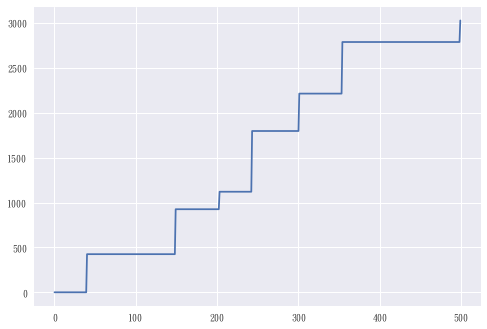

In [24]:

(condit, rng) = condit_per(sign_list.iloc[start:end], min_sort_list[0], limt = 1, per=-1, dec=1)
backtest(condit, df=signal.df_price.iloc[start:end], K=1, file_name=None, daylimt=39, plot=True)


# 3流程

## 3.1進場評分指標天數選擇

不同進場評分指標天數有不同的結果，測試 10，20，...，50 


In [50]:

# 不同進場評分指標天數有不同的結果，測試 10，20，...，50
method_day = [i for i in range(10,51,10)]
method = [signal.main_af2(i) for i in method_day]



for i,value in enumerate(method):
    # 相關係數表
    per = stat_per_af(sign_list, value, start, end) 
    pss = pearson_sort( # 相關係數前3名(絕對值)，返回名稱
        3,
        per.abs().sort_values(by = [0], ascending = False),
        name_list
    )
    
    print(
        f'進場評分指標天數: {method_day[i]}', # 不同天數
        '\n',
        '-'*50,
        '\n',
        per.loc[pss][0], # 透過名稱取得結果
        '\n'
    )


進場評分指標天數: 10 
 -------------------------------------------------- 
 MTM136          -0.368714
RSI136          -0.350330
MACD,15,22,15   -0.295487
Name: 0, dtype: float64 

進場評分指標天數: 20 
 -------------------------------------------------- 
 MTM136   -0.517900
RSI136   -0.490279
MA_200   -0.423262
Name: 0, dtype: float64 

進場評分指標天數: 30 
 -------------------------------------------------- 
 MTM135   -0.582904
RSI135   -0.554175
MA_200   -0.498158
Name: 0, dtype: float64 

進場評分指標天數: 40 
 -------------------------------------------------- 
 MTM135   -0.593334
RSI135   -0.571623
MA_200   -0.520515
Name: 0, dtype: float64 

進場評分指標天數: 50 
 -------------------------------------------------- 
 MTM131   -0.591218
RSI131   -0.577903
MA_200   -0.525332
Name: 0, dtype: float64 



## 3.2進場評分指標天數[40]

進場評分指標天數[40]能夠找到最相關的指標

In [51]:
method = signal.main_af2(40)

## 3.3相關分析輸出結果

In [52]:
# 樣本內相關係數表
pearson = stat_per_af(sign_list, method, start, end)
# 樣本內相關係數表
test_pearson = stat_per_af(sign_list, method, test_start, test_end)

# 相關分析篩選(前3名，由大到小)
max_sort_list = pearson_sort(3,pearson.sort_values(by = [0], ascending = False), name_list)
# 相關分析篩選(前3名，由小到大)
min_sort_list = pearson_sort(3,pearson.sort_values(by = [0], ascending = True), name_list)

# 篩選後的指標名稱(正相關)
max_sort_list
# 篩選後的指標名稱(負相關)
min_sort_list

# 透過名稱，取得相關係數(正相關)
max_per_lis = pearson.loc[max_sort_list,:]
max_per_lis

# 透過名稱，取得相關係數(負相關)
min_per_lis = pearson.loc[min_sort_list,:]
min_per_lis


['WR169', 'v,200,1.1', '期現貨價差(現貨-期貨)']

['MTM135', 'RSI135', 'MA_200']

,0,1
WR169,0.409581,1.199138e-21
"v,200,1.1",0.299923,7.490706e-12
期現貨價差(現貨-期貨),0.168211,1.575516e-04


,0,1
MTM135,-0.593334,7.125199e-49
RSI135,-0.571623,1.022396e-44
MA_200,-0.520515,4.602559e-36



    
<span class="burk">輸出至EXCEL，方便以後查證</span>
    
<span class="burk">PS:此代碼並未執行，為markdown的代碼塊(註記用)</span>


```py
df_to_excel(
    # 合併樣本內外關係數表(正相關)
    pd.concat(
        [
            # 樣本內關係數表
            pearson.loc[max_sort_list,:],
            # 樣本外關係數表
            test_pearson.loc[max_sort_list,:]
        ],
        axis=1
    ),
    file_name='pearson'+'正'
)

df_to_excel(
    # 合併樣本內外關係數表(正相關)
    pd.concat(
        [
            # 樣本內關係數表
            pearson.loc[min_sort_list,:],
            # 樣本外關係數表
            test_pearson.loc[min_sort_list,:]
        ],
        axis=1
    ),
    file_name='pearson'+'負'
)
```

## 3.4正負相關各項輸出(做多,做空,多空)

<span class="burk">以下為正負相關各項輸出(做多,做空,多空)，結果眾多，太佔篇幅，故不執行</span>

In [ ]:


plt.figure()
signal.df_price.iloc[start:end,3].plot()
plt.savefig(str(start)+'stock'+'inside')

plt.figure()
signal.df_price.iloc[test_start:test_end,3].plot()
plt.savefig(str(start)+'stock'+'TEST')

df_to_excel(max_per_lis, file_name=str(start)+'相關係數_大到小')
df_to_excel(min_per_lis, file_name=str(start)+'相關係數_小到大')

plot_af(str(start)+'stock'+'pearson',method,start,end)
plot_af(str(test_start)+'stock'+'pearson',method,test_start,test_end)

for k in ['正相關','負相關']:
    if k =='正相關':
        per = 1
        sort_list = max_sort_list
        per_lis = max_per_lis
    elif k =='負相關':
        per = -1
        sort_list = min_sort_list
        per_lis = min_per_lis
    for i in range(3):
        plot_af_signal(k+str(i), sign_list, sort_list[i], method, start, end)
        plot_af_signal(k+str(i)+'TEST', sign_list, sort_list[i], method, test_start, test_end)
        for j in ['做多','做空','多空']:
            if j == '做多':
                dec = 1
            elif j == '做空':
                dec = -1
            elif j == '多空':
                dec = 0
            
            file_name = str(start) + k + str(i) + sort_list[i] + j
            # 訓練期
            (condit, rng) = condit_per(sign_list.iloc[start:end], sort_list[i], limt = 1, per=per, dec=dec)
            xx = per_lis.loc[sort_list[i]].copy()
            xx[2] = rng
            df_to_excel(xx, file_name=file_name+'_cond')
            backtest(
                condit,
                df=signal.df_price.iloc[start:end],
                K=1, 
                file_name=file_name+'inside',
                daylimt=39,
                plot=False
            )
            
            # 測試期 
            condit = condit_per_test(sign_list.iloc[test_start:test_end], sort_list[i], rng, per=per, dec=dec)
            backtest(
                condit, 
                df=signal.df_price.iloc[test_start:test_end], 
                K=1, file_name=file_name+'TEST', daylimt=39, plot=False
            )

# 4BPN

## 4.1正負相關 6 個指標

In [53]:
## 相關資料
max_sort_list # 正相關前3高
min_sort_list # 負相關前3高
# 正負相關 6 個指標
max_min_list = max_sort_list+min_sort_list
# 進場評分指標
method.tail()
# 指標表
sign_list.tail()


['WR169', 'v,200,1.1', '期現貨價差(現貨-期貨)']

['MTM135', 'RSI135', 'MA_200']

時間
2017-12-20   -12.0
2017-12-21   -10.0
2017-12-22   -48.0
2017-12-25   -40.0
2017-12-26    56.5
dtype: float64

,K5,D5,RSV5,K6,D6,RSV6,K7,D7,RSV7,K8,...,自營商未平倉賣口,自營商未平倉淨口,外資及陸資未平倉買口,外資及陸資未平倉賣口,外資及陸資未平倉淨口,三大法人未平倉買口,三大法人未平倉賣口,三大法人未平倉淨口,未平倉,未平倉變化
時間,,,,,,,,,,,,,,,,,,,,,
2017-12-20,45.657865,47.325079,47.204969,48.518669,48.028133,47.204969,52.287339,48.928118,56.632653,54.261268,...,8651,-4196,65699,20117,45582,71882,63947,7935,30811,-12436
2017-12-21,51.342532,48.664230,62.711864,47.666690,47.907652,45.962733,50.179137,49.345125,45.962733,54.711594,...,8474,-4320,65705,22131,43574,71583,66084,5499,87835,57024
2017-12-22,65.478355,54.268938,93.750000,63.416211,53.077172,94.915254,56.641164,51.777138,69.565217,59.662802,...,9138,-4608,66338,21169,45169,72647,65195,7452,87459,-376
2017-12-25,66.241768,58.259881,67.768595,64.867006,57.007116,67.768595,62.003200,55.185825,72.727273,61.307292,...,9640,-5217,66574,21024,45550,72705,65607,7098,88085,626
2017-12-26,46.481854,54.333872,6.962025,45.565346,53.193193,6.962025,43.656142,51.342597,6.962025,43.192203,...,10596,-6115,66042,22619,43423,72051,69507,2544,91544,3459


## 4.2資料正規化

類神經網路對於輸入輸出數值是敏感的，因此將輸入變數與輸出變數，壓縮至0 ~ 1區間(稱之為正規化)。

使用套件函數將輸入變數與輸出變數正規化至0 ~ 1區間，其中要加np.atleast_2d的原因是套件不接受1維資料(500,)，而np.atleast_2d可使資料最少為2維(1,500)，.T轉置將資料變為(500,1)。


In [54]:
## 資料正規化套件
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler() # feature_range=(0,1) 指定壓縮後的區間，默認(0,1)
y_scaler = MinMaxScaler() # feature_range=(0,1) 指定壓縮後的區間，默認(0,1)
# 帶入樣本內資料並轉換(輸入變數:正負相關 6 個指標)
X_train = X_scaler.fit_transform( 
    sign_list.loc[:,max_min_list].iloc[start:end]
)
# 帶入樣本內資料並轉換(輸出變數:隔日進場評分指標)
y_train = y_scaler.fit_transform(
    np.atleast_2d(method.shift(-1).iloc[start:end]).T
)
# 轉換樣本外資料(輸入變數:正負相關 6 個指標)
X_test = X_scaler.transform(
    sign_list.loc[:,max_min_list].iloc[test_start:test_end]
)
# 轉換樣本外資料(輸出變數:隔日進場評分指標)
y_test = y_scaler.transform(
    np.atleast_2d(method.shift(-1).iloc[test_start:test_end]).T
)


## 4.3類神經參數選擇

In [55]:
%%html
<!--為了使表格置右-->
<style>
    table {margin-left: 0 !important;}
    td {align="center"}
</style>


**類神經參數使用**

使用參數 | 內容
-|-
activation | 激活函數{ ‘logistic’, ‘tanh’, ‘relu’}，<br>‘logistic’為S型函數(Sigmoid Function)，<br>‘tanh’為雙曲正切函數(Tanh Function)，<br>‘relu’為線性整流函數(ReLU)。
solver | ‘sgd’：隨機梯度下降，隨機抽取一組訓練範例，進行倒傳遞學習。
hidden_layer_sizes | 加倍法：2*7(正負相關6個指標+輸出變數)，<br>總合法：7(正負相關6個指標+輸出變數)，<br>平均法：4(7/2，四捨五入至4)
random_state | 隨機數種子，確保每次的隨機數一致
learning_rate_init | 學習速率0.1~0.9
momentum | 慣性因子0.1~0.9


**<span class="burk">以下為類神經不同參數的相關係數表的輸出，結果眾多，太佔篇幅，故不執行</span>**

In [ ]:

from sklearn.neural_network import MLPRegressor

s_p ={'logistic':np.zeros((9,9)), 'tanh':np.zeros((9,9)), 'relu':np.zeros((9,9))}
for k in ['tanh', 'relu', 'logistic']:
    for i in range(1,10):
        for j in range(1,10):
            Reg = MLPRegressor(activation=k, solver = 'sgd', hidden_layer_sizes=(4),
                               max_iter=200, random_state=0, #batch_size=1,
                               learning_rate_init=i/10, momentum=j/10)

            Reg.fit(X_train,y_train.ravel())
            y_predict = Reg.predict(X_train)
            s_p[k][i-1,j-1],_=stats.pearsonr(y_predict,y_train.ravel())
            
# 'tanh', 'relu', 'logistic'
# df_to_excel(pd.DataFrame(s_p['relu']).round(3),file_name='平均法relu')
# pd.DataFrame(s_p['relu']).round(3)

# df_to_excel(pd.DataFrame(s_p['tanh']).round(3),file_name='平均法tanh')
# pd.DataFrame(s_p['tanh']).round(3)

# df_to_excel(pd.DataFrame(s_p['logistic']).round(3),file_name='平均法logistic')
# pd.DataFrame(s_p['logistic']).round(3)</div><i class="fa fa-lightbulb-o "></i>

## 4.4類神經

經過類神經參數選擇後，以以下的結果能產生最高的相關係數的類神經模型

In [42]:

## 類神經套件
from sklearn.neural_network import MLPRegressor
# 類神經網路參數
Reg = MLPRegressor(
    activation='relu', 
    solver = 'sgd', 
    hidden_layer_sizes=(7*2),
    random_state=0, 
    learning_rate_init=0.4, 
    momentum=0.9
)
# 類神經訓練
Reg.fit(X_train,y_train.ravel())
# 類神經預測
y_predict = Reg.predict(X_train)
# 樣本內相關係數
stats.pearsonr(y_predict,y_train.ravel())[0]
# 樣本外相關係數
stats.pearsonr(Reg.predict(X_test),y_test.ravel())[0]


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=14, learning_rate='constant',
       learning_rate_init=0.4, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

0.6544994675785946

0.19727656338010935

**經過正則化的進場評分指標與類神經模型(樣本內)**

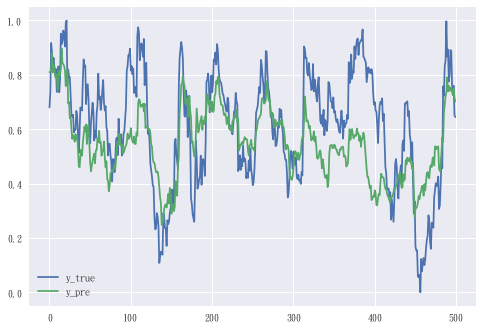

In [35]:
y_predict = Reg.predict(X_train)
pd.DataFrame([y_train.ravel(),y_predict],index=['y_true','y_pre']).T.plot()

**經過正則化的進場評分指標與類神經模型(樣本外)**

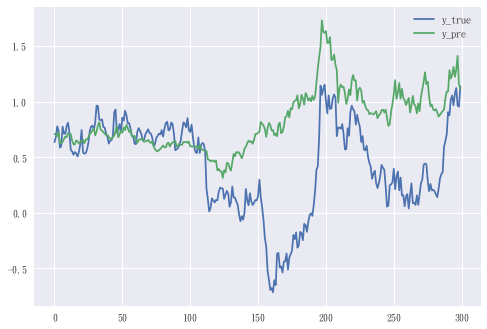

In [36]:

pd.DataFrame([y_test.ravel(),Reg.predict(X_test)],index=['y_true','y_pre']).T.plot()

## 4.5類神經交易

In [39]:
y_pred = pd.DataFrame({'pred':Reg.predict(X_train)})
y_pred_test = pd.DataFrame({'pred':Reg.predict(X_test)})

# 訓練期
print('訓練期'+'-'*30)
(condit, rng) = condit_per(y_pred, 'pred', limt = 1, per=1, dec=0)
backtest(condit, df=signal.df_price.iloc[start:end], K=1,  file_name=None, daylimt=39, plot=False)

# 測試期
print('測試期'+'-'*30)
condit = condit_per_test(y_pred_test,'pred', rng, per=1, dec=0)       
backtest(condit, df=signal.df_price.iloc[test_start:test_end], K=1,  file_name=None, daylimt=39, plot=False)

訓練期------------------------------


,0
淨損益,3823.000
單位風險報酬,1.021
獲利因子,9.048
交易次數,13.000
勝率,0.846
最大回損,475.000


測試期------------------------------


,0
淨損益,-315.000
單位風險報酬,-0.094
獲利因子,0.787
交易次數,7.000
勝率,0.571
最大回損,1426.000


## 4.6類神經所有結果(做多,做空,多空)

**<span class="burk">以下為類神經類神經所有結果(做多,做空,多空)的輸出，結果眾多，太佔篇幅，故不執行</span>**

In [ ]:
y_pred = pd.DataFrame({'pred':Reg.predict(X_train)})
y_pred_test = pd.DataFrame({'pred':Reg.predict(X_test)})
for j in ['做多','做空','多空']:
    if j == '做多':
        dec = 1
    elif j == '做空':
        dec = -1
    elif j == '多空':
        dec = 0
    (condit, rng) = condit_per(y_pred, 'pred', limt = 1, per=1, dec=dec)
    
    backtest(condit, df=signal.df_price.iloc[start:end], K=1, file_name=j+'pred', daylimt=39, plot=False)
    
    condit = condit_per_test(y_pred_test,'pred', rng, per=1, dec=dec)       
    backtest(condit, df=signal.df_price.iloc[test_start:test_end], K=1, file_name=j+'pred'+'TEST', daylimt=39, plot=False)